This is my Final notebook of modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import XGBRegressor
import shap

In [2]:
# read in the data
df= pd.read_csv('master.csv')

In [3]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


This code splits them up by the year and I think I like the split

In [4]:
def cleanUp(df):
    #reformat gdp so it doesn't have commas
    df['annual_gdp']=df[' gdp_for_year ($) '].str.replace(',','')
    
    #GDP can be dropped now because of dupilication, country year and suicides no are both irrelivant
    df=df.drop([' gdp_for_year ($) ','country-year', 'suicides_no'], axis=1)
    
    #This is a number and should be treated as such
    df['annual_gdp']=df['annual_gdp'].astype(int)
    
    #theres a bunch of missing values for HDI, This code replaces them with the average for their respective countries
    countrySer=df.groupby('country')["HDI for year"].mean()
    def HDIcleanup(data):
        country=data[0]
        HDI=data[1]
        if np.isnan(HDI):       
            return countrySer[country]
        else:
            return HDI
    df['HDI_for_year']=df[['country','HDI for year']].apply(HDIcleanup,axis=1)
    
    #get rid of the duplicate colum with an unfortunate name
    df=df.drop('HDI for year', axis=1)
    #for some countries the HDI was always missing. I would rather drop those countries than make something up
    df=df.dropna()
    #the target vector needs the year for the train/test split, will be removed durring that step
    y=df[['year','suicides/100k pop']]
    #remove the target vector
    df=df.drop('suicides/100k pop',axis=1)
    return df, y

In [5]:
df, y=cleanUp(df)

In [6]:
df.head()

,country,year,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
0,Albania,1987,male,15-24 years,312900,796,Generation X,2156624900,0.673
1,Albania,1987,male,35-54 years,308000,796,Silent,2156624900,0.673
2,Albania,1987,female,15-24 years,289700,796,Generation X,2156624900,0.673
3,Albania,1987,male,75+ years,21800,796,G.I. Generation,2156624900,0.673
4,Albania,1987,male,25-34 years,274300,796,Boomers,2156624900,0.673


In [7]:
#perform a train val test split based on time. 
X_train=df[df['year']<2005]
X_val=df[(df['year']>=2005) & (df['year']<2010)]
X_test=df[df['year']>=2010]
y_train=y[y['year']<2005]['suicides/100k pop']
y_val=y[(y['year']>=2005) & (y['year']<2010)]['suicides/100k pop']
y_test=y[y['year']>=2010]['suicides/100k pop']
X_train.shape, X_val.shape, X_test.shape,y_train.shape,y_val.shape,y_test.shape

((15840, 9), (4896, 9), (5598, 9), (15840,), (4896,), (5598,))

In [8]:
#begin with mean baseline
y_train.mean()
y_pred=np.full_like(y_train, y_train.mean())
mean_absolute_error(y_train, y_pred)

13.089125216416049

In [9]:
#I've enjoyed the results of an XGB regressor in class, try it first
encoder=ce.OrdinalEncoder()
modelXG=XGBRegressor(n_estimators=5000, learning_rate=.5, n_jobs=-1)

In [10]:
X_train_enc=encoder.fit_transform(X_train)
X_val_enc=encoder.transform(X_val)
X_test_enc=encoder.transform(X_test)

evals=[(X_train_enc,y_train),(X_val_enc, y_val)]
#this model gets a really good validation mae. 
modelXG.fit(X_train_enc, y_train, eval_set=evals, early_stopping_rounds=50, eval_metric='mae')

[0]	validation_0-mae:9.18258	validation_1-mae:7.78217
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:8.71287	validation_1-mae:7.84384
[2]	validation_0-mae:8.71392	validation_1-mae:8.08816
[3]	validation_0-mae:8.57015	validation_1-mae:8.32094
[4]	validation_0-mae:8.39927	validation_1-mae:8.32223
[5]	validation_0-mae:8.2516	validation_1-mae:8.40392
[6]	validation_0-mae:8.1607	validation_1-mae:8.2101
[7]	validation_0-mae:8.03105	validation_1-mae:8.06729
[8]	validation_0-mae:7.98826	validation_1-mae:8.06518
[9]	validation_0-mae:7.82457	validation_1-mae:7.96504
[10]	validation_0-mae:7.72626	validation_1-mae:7.74915
[11]	validation_0-mae:7.65151	validation_1-mae:7.7346
[12]	validation_0-mae:7.59736	validation_1-mae:7.67321
[13]	validation_0-mae:7.48818	validation_1-mae:7.593
[14]	validation_0-mae:7.48549	validation_1-mae:7.60475
[15]	validation_0-mae:7.44655	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [11]:
row=X_train.iloc[[6184]]
row

,country,year,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
10206,Greece,2000,male,15-24 years,823264,12509,Generation X,130133845771,0.799


In [12]:
#its going to be worth knowing the actual value for the write up 
y_train.iloc[[6184]]

10206    3.77
Name: suicides/100k pop, dtype: float64

In [13]:
#this model is predicting less than 0 suicides per year. This implies people are bringing themselves back from the dead which doesn't make much sense
modelXG.predict(X_train_enc).min()

-17.993376

In [14]:
#set up the shap plot
explainer=shap.TreeExplainer(modelXG)
row_enc=encoder.transform(row)
shap_values= explainer.shap_values(row_enc)
modelXG.predict(row_enc)

array([-0.52921784], dtype=float32)

In [15]:
#run the shap plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values, 
    features=row
)

In [16]:
#try another model to see what the predictions are going to look like here 
model=RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_enc, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [17]:
-cross_val_score(model,X_val_enc,y_val, cv=5, scoring='neg_mean_absolute_error').mean()
#that score isn't as good as the XGB, lets check in on range

8.191488298555377

In [18]:
#thats much more like what I think I'm looking for
model.predict(X_train_enc).min()

0.0

In [19]:
#set up the shap plot for the tree
explainer=shap.TreeExplainer(model)
row_enc=encoder.transform(row)
shap_values= explainer.shap_values(row_enc)
model.predict(row_enc)

array([3.9823])

In [20]:
#display tree shap. In the write up this prediction is listed as 3.9, due to the nature of random trees this is going to change with each run though
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values, 
    features=row
)

The random forest regressor is giving more accurate results because it doesn't predict values less than 0. I'm not sure why this is.

In [21]:
#create a function to set up shap Plots for any row/model
def shapPlot(row_num, model, df):
    explainer=shap.TreeExplainer(model)
    row=df.loc[[row_num]]
    row_enc=encoder.transform(row)
    shap_values= explainer.shap_values(row_enc)
    
    shap.initjs()
    
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=row
    )

In [22]:
shapPlot(24188, model, X_train)

In [23]:
import eli5
from eli5.sklearn import PermutationImportance

In [24]:
#set up to check permutation importance through an ELI5 plot
permuter= PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5
)

permuter.fit(X_train_enc, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [25]:
#show the plot
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_train.columns.tolist()
)

Weight,Feature
6.9987 ± 0.0518,sex
6.9330 ± 0.0552,HDI_for_year
6.7671 ± 0.1056,age
4.8922 ± 0.0652,annual_gdp
4.5983 ± 0.0380,gdp_per_capita ($)
4.2866 ± 0.0771,country
4.0236 ± 0.0594,population
1.2443 ± 0.0270,year
1.0352 ± 0.0308,generation


it makes a significant difference to have the suicides normalized. I need to also do this on the yearly model to see what the trends look like. 

In [26]:
#pdp plots are easier with a function to do them
def pdpSingle(feature, model, df):
    df_enc=encoder.transform(df)
    isolated= pdp_isolate(
        model=model,
        dataset=df_enc,
        model_features=df.columns.tolist(),
        feature=feature,
        num_grid_points=200
    )
    
    return pdp_plot(isolated, feature, plot_lines=True, frac_to_plot=30)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2bc07c18>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2c113d68>})

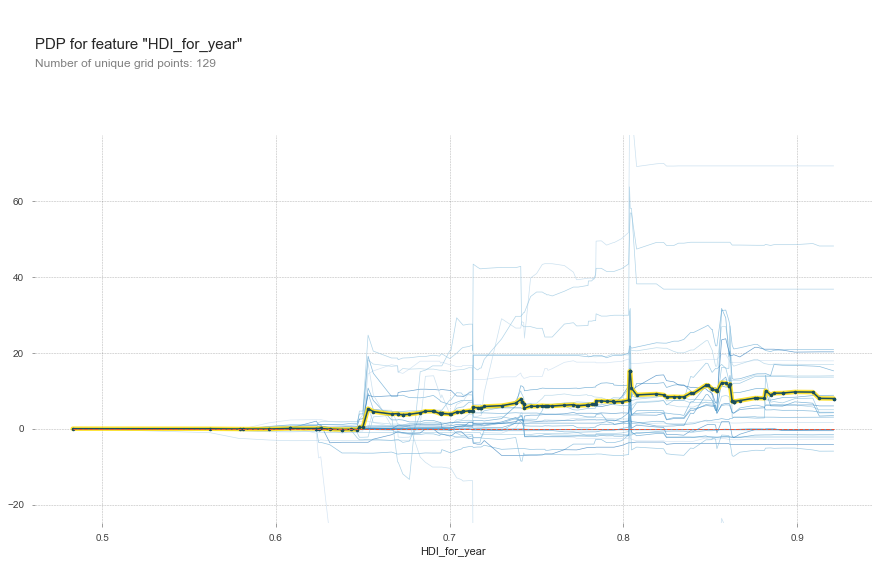

In [27]:
#checking out the forest versus the XGB 
pdpSingle('HDI_for_year', model, X_train)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c334734a8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c3345f5c0>})

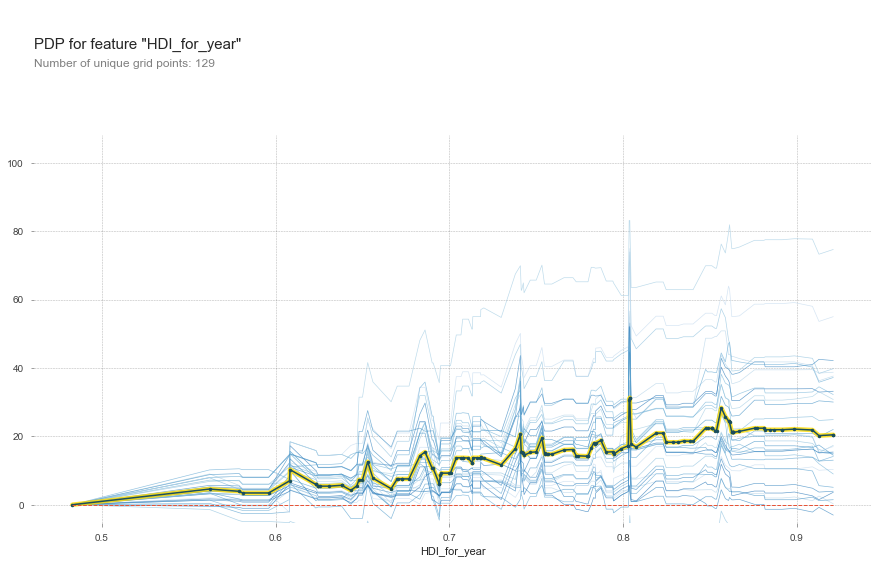

In [28]:
pdpSingle('HDI_for_year',modelXG, X_train)

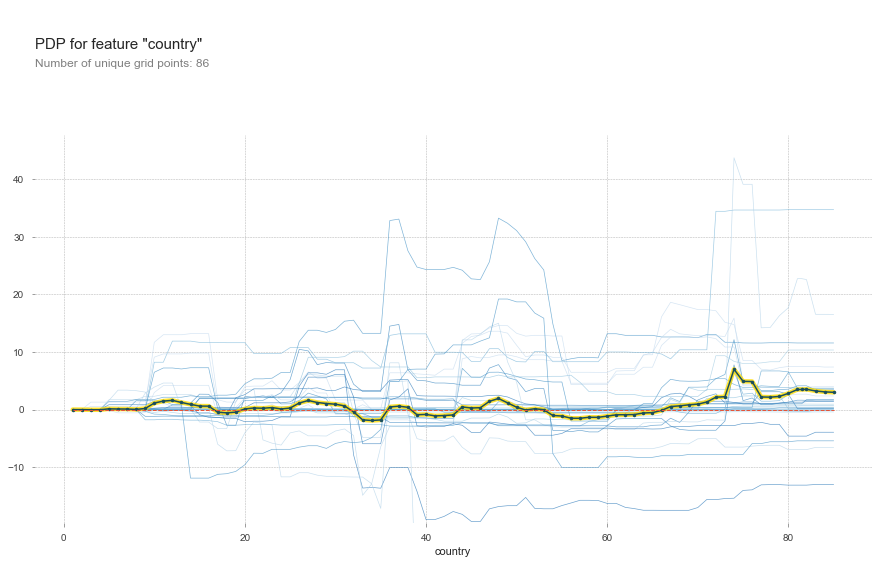

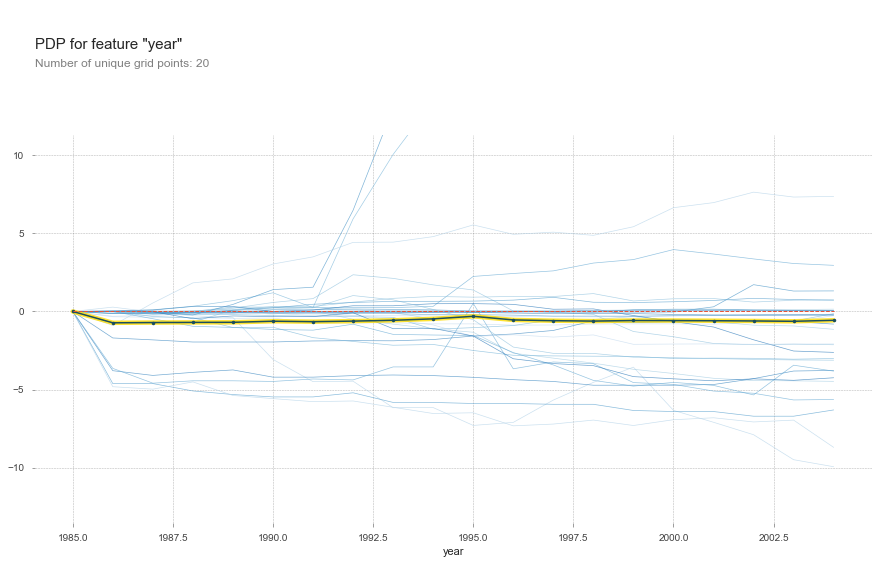

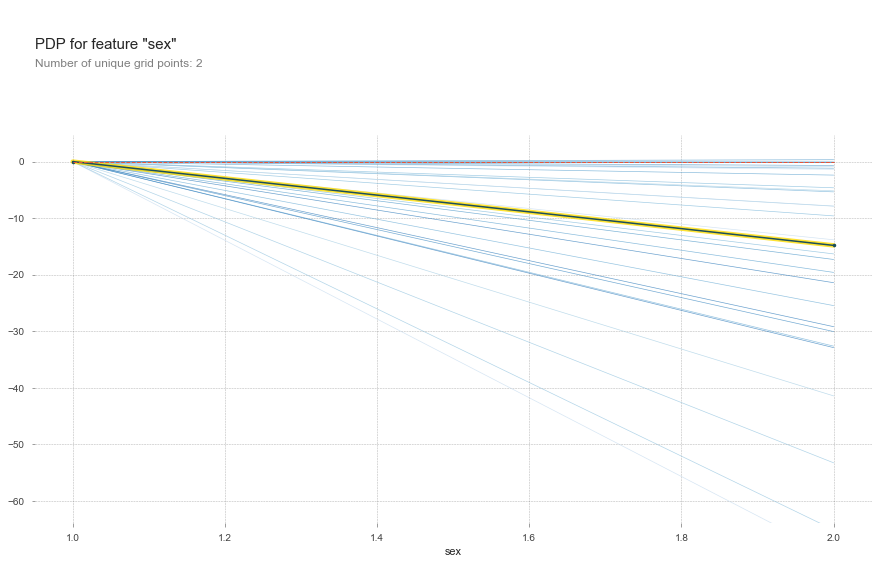

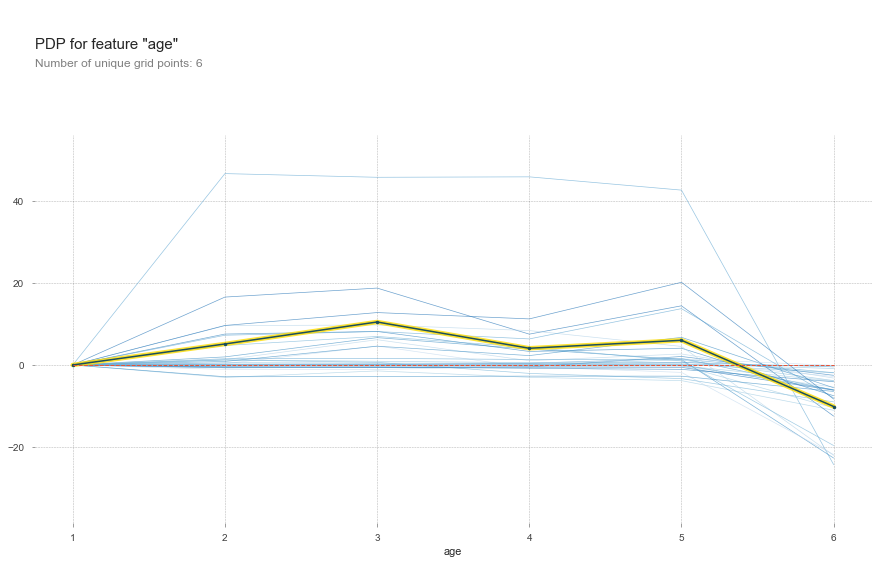

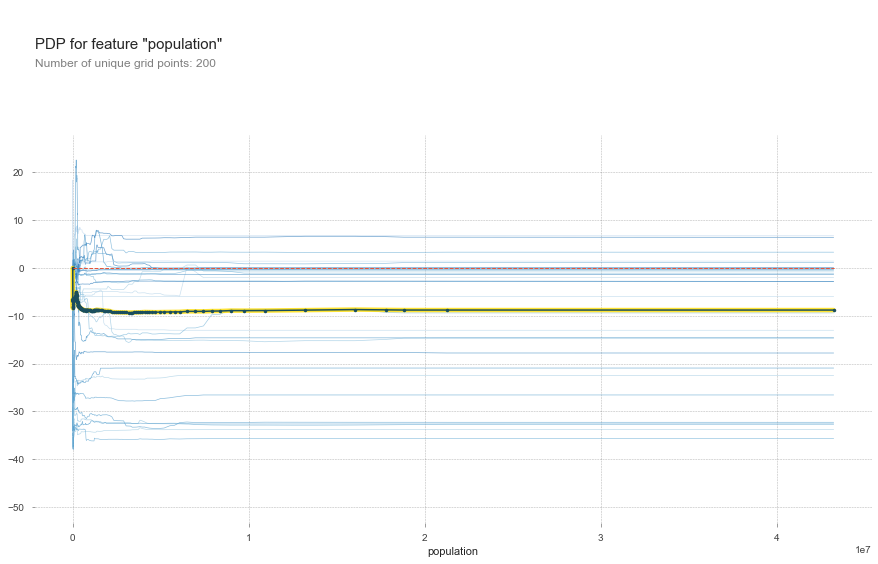

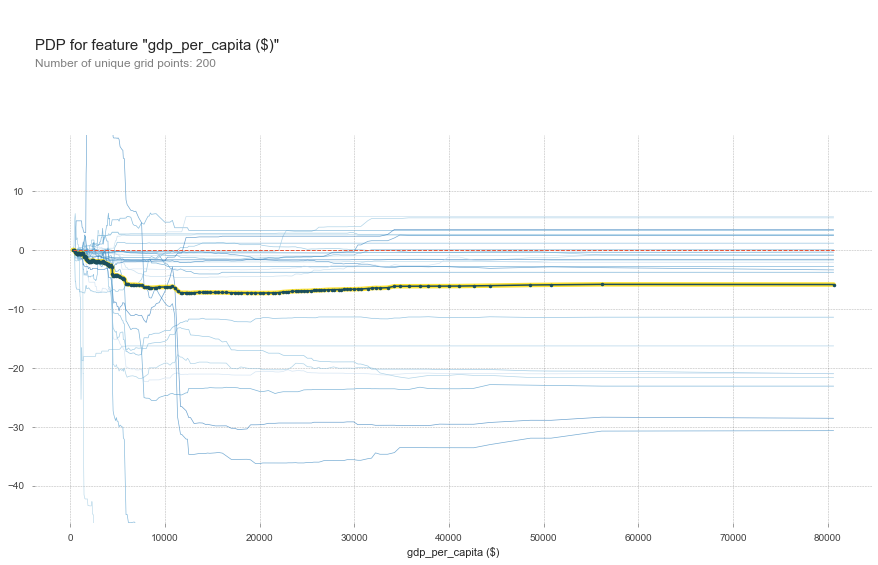

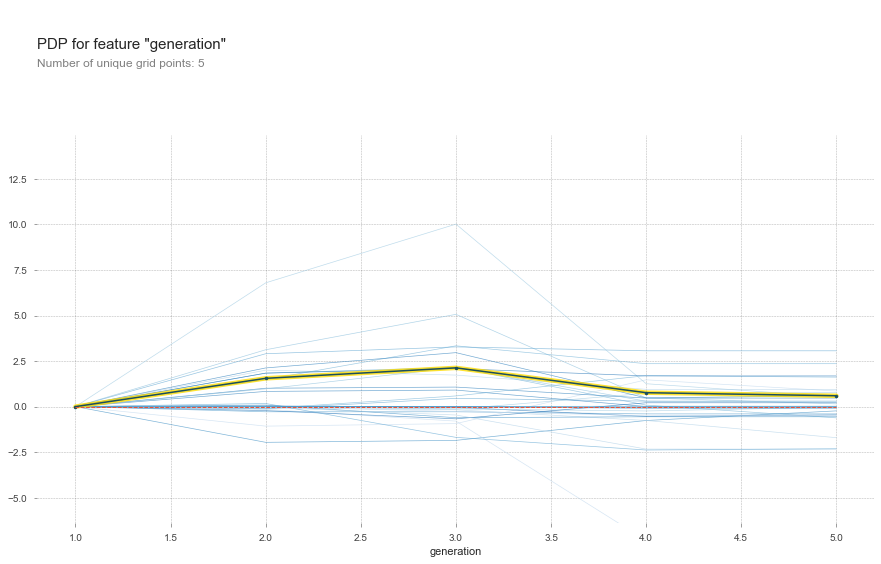

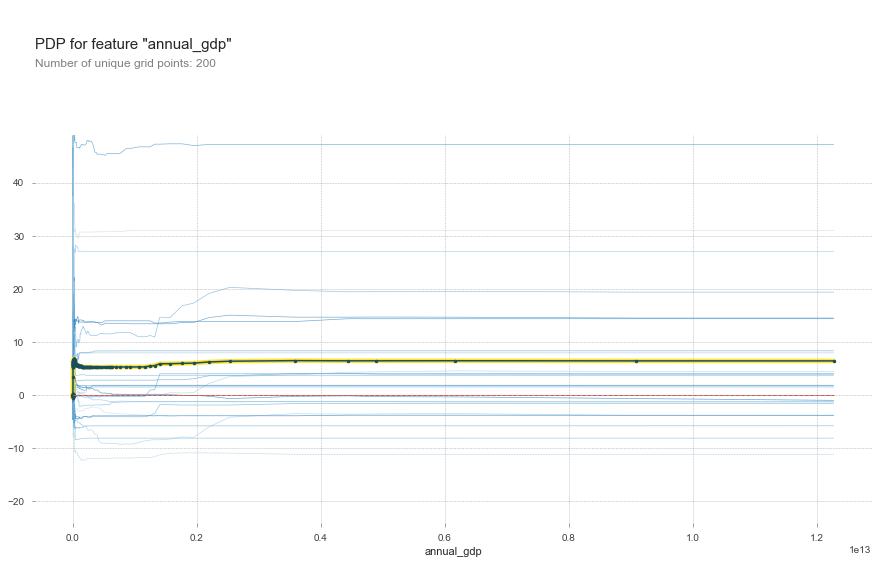

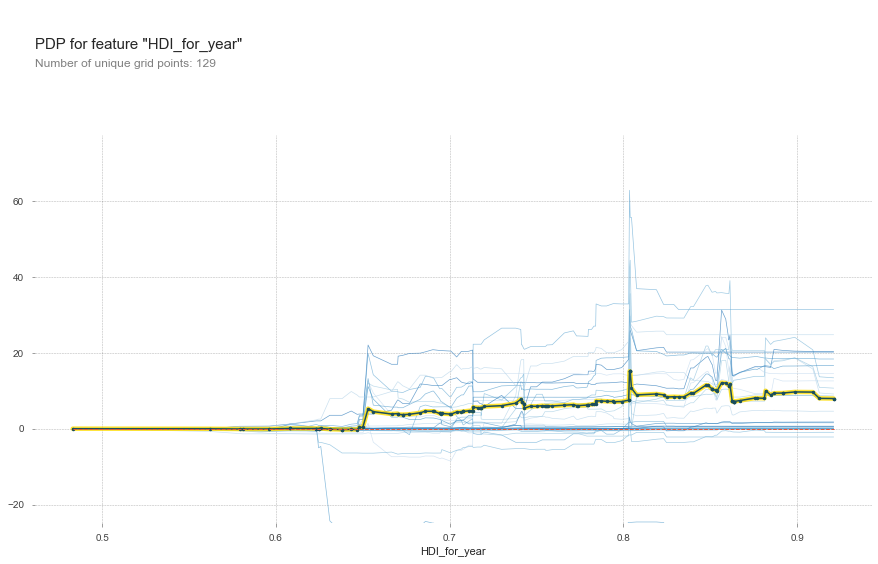

In [29]:
#check all the PDP's to see if there are any surprises 
for col in X_train.columns.tolist():
    pdpSingle(col, model, X_train)

I think that HDI_for_year graph is the most depressing thing I've created yet. The Human Development Index measures the standard of living in a country, the closer to one it is the better the standard of living. The PDP shows that generally, as the HDI goes up, so does the rate of suicides per 100k.

I don't Know what I was messing with below this because I didn't note it at the time. I believe that the thought was just messing around to take a look at the predictions 

In [30]:
y_pred=model.predict(X_train_enc)

In [31]:
(y_pred==0).sum()

544

In [32]:
X_train_enc['prediction']=y_pred
X_train_enc['actual']=y_train

In [33]:
#check to see the predictions versus actual and whether they tend to be higher or lower than actual values
X_train_enc[X_train_enc['actual']-X_train_enc['prediction']>0].shape, X_train_enc[X_train_enc['actual']-X_train_enc['prediction']<0].shape

((6399, 11), (8897, 11))

The model tends to predict values that are lower than the actual values

In [34]:
#look at one that was predicted to be 0
shapPlot(10471, model, X_train)